In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [3]:
class Value:
    def __init__(self,data,_children=(),op='',label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self.label = label
        self._op = op
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data,(self,other),'+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward
        return out
    def __radd__(self,other):
        return self + other
    def __repr__(self):
        return f'Value(data={self.data})'
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data,(self,other),'*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        return out
    def __rmul__(self,other):
        return self * other
    def __sub__(self,other):
        return self + other*(-1)
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x)+1)
        out = Value(t,(self,),'tanh')
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out
    def __pow__(self,other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other,(self,),'^')
        def _backward():
            self.grad += other*self.data **(other-1)  *out.grad
        out._backward = _backward
        return out

    def backward(self):
        s = [] # list of sorted elements
        visited = set() # set of visited elements
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                s.append(v)
        build_topo(self)
        self.grad = 1.0
        for v in reversed(s):
            v._backward()
        

In [4]:
df = Value(2.0)
xd = Value(-1.0)
print(df-xd)

Value(data=3.0)


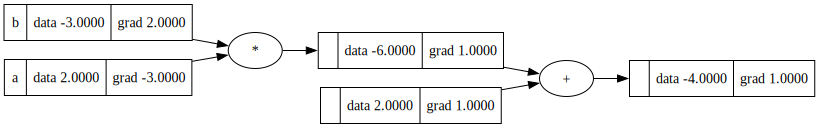

In [5]:
a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = b*a
d = c+2
#d =d.tanh()
d.backward()
draw_dot(d)

In [6]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.random()) for _ in range(nin)]
        self.b = Value(random.random())
    def __call__(self,x):
        out = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out = out.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
        

In [7]:
class Layer:
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range (nout)]
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

In [8]:
class MLP:
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    def __call__(self,x):
        for n in self.layers:
            x = n(x)
        return x
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]



In [13]:
n = MLP(4,[4,4,4,1])
x = [0.1,0.2,0.3]
n(x)

Value(data=0.9676019879309746)

In [14]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [17]:
for k in range(200):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) * (yout - ygt) for ygt, yout in zip(ys,ypred))

    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    for p in n.parameters():
        p.data += -0.1*p.grad
    print(k,loss)

0 Value(data=0.00386316980486195)
1 Value(data=0.0038012351364036536)
2 Value(data=0.0037411539469809196)
3 Value(data=0.003682845967316839)
4 Value(data=0.0036262354489189318)
5 Value(data=0.00357125085216278)
6 Value(data=0.0035178245597495316)
7 Value(data=0.003465892613167639)
8 Value(data=0.0034153944700381147)
9 Value(data=0.0033662727804433497)
10 Value(data=0.0033184731805334386)
11 Value(data=0.003271944101877035)
12 Value(data=0.0032266365951769092)
13 Value(data=0.0031825041671066324)
14 Value(data=0.0031395026291458636)
15 Value(data=0.003097589957400306)
16 Value(data=0.003056726162488563)
17 Value(data=0.0030168731686650322)
18 Value(data=0.002977994701424732)
19 Value(data=0.002940056182905793)
20 Value(data=0.0029030246344673967)
21 Value(data=0.002866868585876939)
22 Value(data=0.002831557990590768)
23 Value(data=0.002797064146657869)
24 Value(data=0.0027633596228172795)
25 Value(data=0.002730418189396568)
26 Value(data=0.002698214753652761)
27 Value(data=0.00266672529

In [18]:
ypred

[Value(data=0.9838925290797725),
 Value(data=-0.9981603553045248),
 Value(data=-0.9827727638589767),
 Value(data=0.9829323616082126)]

In [20]:
len(n.parameters())

65